In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, f1_score, accuracy_score
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.utils import class_weight

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import pearsonr

from functions.nn import *

#### Attempting to create an NN but with rolling window

In [36]:
data = pd.read_csv('eurusd_final_dataset.csv')
data = data.drop(['Date_Time'], axis=1)

X = data.drop(['label'], axis=1)
y = data['label'].astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit(X)


In [39]:
# Parameters
window_size = 5000
val_size = 1000
step = 1000
cost_per_trade = 1.5  # in pips

input_features = X.shape[1]

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dense(5, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Tracking
f1_per_window, acc_per_window, profit_per_window = [], [], []
vol_per_window, trend_15_per_window, vol_1h_per_window = [], [], []
window_indices = []

duration_by_class = {0: [], 1: [], 3: [], 4: []}

# SL/TP search space
tp_values = [10, 20, 30, 40]
sl_values = [8, 10, 12, 14]

class_to_direction = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}

# Market data
volatility_local = data['vol_local'].values
trend_15m = data['roll_m15_trend'].values
vol_1h = data['roll_h1_vol'].values
close_prices = data['Close'].values
highs_full = data['High'].values
lows_full = data['Low'].values

# Prediction horizon
steps = int(60 / 5)  # 1 hour = 12 candles

# --- Phase 1: Optimize SL/TP per class ---
print("\n--- Optimizing SL/TP per class ---")
sl_tp_map = {}
for cls in [0, 1, 3, 4]:
    best_profit = -np.inf
    best_pair = (12, 20)
    for sl in sl_values:
        for tp in tp_values:
            temp_profit = 0
            count = 0
            for i, start in enumerate(range(0, len(X) - window_size - val_size - steps, step)):
                val_y = y[start+window_size:start+window_size+val_size]
                val_start = start + window_size
                max_len = min(val_size, len(data) - val_start - steps)

                entry_prices = close_prices[val_start:val_start + max_len]
                future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
                future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]
                val_preds = val_y[:max_len]  # use true class as simulated prediction

                for pred, entry, highs_seq, lows_seq in zip(val_preds, entry_prices, future_highs_seq, future_lows_seq):
                    if pred != cls:
                        continue
                    direction = class_to_direction[pred]
                    outcome, _ = simulate_trade(entry, highs_seq, lows_seq, direction, sl, tp)
                    if outcome == 'TP':
                        temp_profit += tp
                    elif outcome == 'SL':
                        temp_profit -= sl
                    temp_profit -= cost_per_trade
                    count += 1
            if count > 0 and temp_profit > best_profit:
                best_profit = temp_profit
                best_pair = (sl, tp)
    sl_tp_map[cls] = {'sl': best_pair[0], 'tp': best_pair[1]}
    print(f"Class {cls}: Best SL/TP = {best_pair} with Profit = {best_profit:.2f}")

# Hardcode for class 2 (no trade)
sl_tp_map[2] = {'sl': None, 'tp': None}


--- Optimizing SL/TP per class ---
Class 0: Best SL/TP = (14, 20) with Profit = 76488.00
Class 1: Best SL/TP = (14, 10) with Profit = 130578.00
Class 3: Best SL/TP = (14, 10) with Profit = 126037.00
Class 4: Best SL/TP = (14, 20) with Profit = 70975.50


In [ ]:
# --- Phase 2: Estimate average SL/TP durations ---
print("\n--- Estimating average SL/TP durations per class ---")
for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size - steps, step)):
    train_y = y[start:start+window_size]
    val_y = y[start+window_size:start+window_size+val_size]

    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - steps)

    entry_prices = close_prices[val_start:val_start + max_len]
    future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    val_preds = val_y[:max_len]  # simulated pred = true class to collect durations

    for pred, entry, highs_seq, lows_seq in zip(val_preds, entry_prices, future_highs_seq, future_lows_seq):
        direction = class_to_direction.get(pred, 0)
        if direction == 0:
            continue

        sltp = sl_tp_map.get(pred, {'sl': None, 'tp': None})
        if sltp['sl'] is None or sltp['tp'] is None:
            continue

        result, duration = simulate_trade(entry, highs_seq, lows_seq, direction, sltp['sl'], sltp['tp'])
        if pred in duration_by_class:
            duration_by_class[pred].append(duration)

# Convert to averages
avg_duration_by_class = {k: round(np.mean(v)) if v else steps for k, v in duration_by_class.items()}
print("Average durations (candles):", avg_duration_by_class)


--- Estimating average SL/TP durations per class ---
Average durations (candles): {0: 7, 1: 7, 3: 7, 4: 7}


In [ ]:
# --- Phase 3: Train and evaluate model with optimized SL/TP ---
print("\n--- Training and simulating with optimized SL/TP ---")
for i, start in enumerate(range(0, len(X_scaled) - window_size - val_size - steps, step)):
    train_X = X_scaled[start:start+window_size]
    val_X = X_scaled[start+window_size:start+window_size+val_size]
    train_y = y[start:start+window_size]
    val_y = y[start+window_size:start+window_size+val_size]

    train_y_cat = to_categorical(train_y, num_classes=5)
    val_y_cat = to_categorical(val_y, num_classes=5)

    cw = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_y), y=train_y)))

    model = build_model(train_X.shape[1])
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=30, batch_size=32,
              class_weight=cw,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    preds = np.argmax(model.predict(val_X, verbose=0), axis=1)
    f1 = f1_score(val_y, preds, average='weighted')
    acc = accuracy_score(val_y, preds)

    # Trade simulation
    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - steps)

    entry_prices = close_prices[val_start:val_start + max_len]
    future_highs_seq = [highs_full[t:t+steps] for t in range(val_start, val_start + max_len)]
    future_lows_seq = [lows_full[t:t+steps] for t in range(val_start, val_start + max_len)]

    profit = 0
    trades = 0

    for pred, entry, highs_seq, lows_seq in zip(preds[:max_len], entry_prices, future_highs_seq, future_lows_seq):
        direction = class_to_direction.get(pred, 0)
        if direction == 0:
            continue

        sltp = sl_tp_map.get(pred, {'sl': None, 'tp': None})
        if sltp['sl'] is None or sltp['tp'] is None:
            continue

        limit = avg_duration_by_class.get(pred, steps)
        highs_limited = highs_seq[:limit]
        lows_limited = lows_seq[:limit]

        outcome, duration = simulate_trade(entry, highs_limited, lows_limited, direction, sltp['sl'], sltp['tp'])

        if outcome == 'TP':
            result = sltp['tp']
        elif outcome == 'SL':
            result = -sltp['sl']
        else:
            result = 0

        result -= cost_per_trade
        profit += result
        trades += 1

    # Log
    profit_per_window.append(profit)
    f1_per_window.append(f1)
    acc_per_window.append(acc)
    vol_per_window.append(np.mean(volatility_local[val_start:val_start + val_size]))
    trend_15_per_window.append(np.mean(trend_15m[val_start:val_start + val_size]))
    vol_1h_per_window.append(np.mean(vol_1h[val_start:val_start + val_size]))
    window_indices.append(i)

    print(f"Window {i}: F1 = {f1:.3f}, Accuracy = {acc:.3f}, Profit = {profit:.2f}, Trades = {trades}")



--- Training and simulating with optimized SL/TP ---
Window 0: F1 = 0.550, Accuracy = 0.482, Profit = -688.00, Trades = 500
Window 1: F1 = 0.566, Accuracy = 0.504, Profit = -465.00, Trades = 510
Window 2: F1 = 0.426, Accuracy = 0.340, Profit = -700.00, Trades = 688
Window 3: F1 = 0.667, Accuracy = 0.629, Profit = -494.00, Trades = 308
Window 4: F1 = 0.554, Accuracy = 0.500, Profit = -562.50, Trades = 483
Window 5: F1 = 0.652, Accuracy = 0.592, Profit = -653.00, Trades = 378
Window 6: F1 = 0.563, Accuracy = 0.551, Profit = -284.00, Trades = 364
Window 7: F1 = 0.543, Accuracy = 0.475, Profit = -510.50, Trades = 503
Window 8: F1 = 0.403, Accuracy = 0.352, Profit = -1645.50, Trades = 649
Window 9: F1 = 0.469, Accuracy = 0.418, Profit = -860.00, Trades = 592
Window 10: F1 = 0.522, Accuracy = 0.433, Profit = -975.00, Trades = 562
Window 11: F1 = 0.485, Accuracy = 0.428, Profit = -978.00, Trades = 540
Window 12: F1 = 0.622, Accuracy = 0.559, Profit = -441.00, Trades = 414
Window 13: F1 = 0.6

KeyboardInterrupt: 

#### Another try

In [51]:
data = pd.read_csv('training_data/eurusd_final_dataset.csv')
data = data.drop(['Date_Time'], axis=1)

X = data.drop(['label'], axis=1)
y = data['label'].astype(int)

In [52]:
# Parameters
window_size = 5000
val_size = 1000
step = 1000

cost_per_trade = 1.5  # in pips

close_prices = X['Close'].values
highs_full = X['High'].values
lows_full = X['Low'].values

# If any are 1-element tuples, extract the array
if isinstance(highs_full, tuple) and len(highs_full) == 1:
    highs_full = highs_full[0]
if isinstance(lows_full, tuple) and len(lows_full) == 1:
    lows_full = lows_full[0]
if isinstance(close_prices, tuple) and len(close_prices) == 1:
    close_prices = close_prices[0]

input_features = X.shape[1]

# Tracking
f1_per_window, acc_per_window, profit_per_window, trade_per_window = [], [], [], []
window_indices = []

class_to_direction = {0: -1, 1: -1, 2: 0, 3: 1, 4: 1}

# Prediction horizon
steps = int(7)  # 7 candles

for i, start in enumerate(range(0, len(X) - window_size - val_size - steps, step)):

    # Standardize per window
    scaler = StandardScaler()
    scaler.fit(X[start : start + window_size])

    # Transform both the training data and the validation data
    X_scaled_train = scaler.transform(X[start : start + window_size])
    X_scaled_val = scaler.transform(X[start + window_size : start + window_size + val_size])
    train_X = X_scaled_train
    val_X = X_scaled_val

    val_y = y[start+window_size:start+window_size+val_size]
    val_y_cat = to_categorical(val_y, num_classes=5)

    train_y = y[start:start+window_size]
    train_y_cat = to_categorical(train_y, num_classes=5)

    # 2. Optimize SL/TP on training window
    sl_tp_map = optimize_sl_tp_per_class(
        y=train_y,
        close_prices=close_prices,
        highs=highs_full,
        lows=lows_full,
        sl_values=[8, 10, 12, 15, 20],
        tp_values=[10, 12, 15, 20, 25],
        class_to_direction=class_to_direction,
        cost_per_trade=cost_per_trade
    )

    # 3. Estimate label horizon per class
    avg_duration_by_class = estimate_avg_duration_per_class(
        y=train_y,
        close_prices=close_prices,
        highs=highs_full,
        lows=lows_full,
        sl_tp_map=sl_tp_map,
        class_to_direction=class_to_direction
    )

    '''# 4. Relabel training window using updated SL/TP and horizons
    train_y = relabel_data(
        X_window,
        sl_tp_map=sl_tp_map,
        avg_duration_by_class=avg_duration_by_class,
        class_to_direction=class_to_direction
    )
    train_y_cat = to_categorical(train_y, num_classes=5)'''

    cw = dict(enumerate(class_weight.compute_class_weight(
        class_weight='balanced', classes=np.unique(train_y), y=train_y)))

    model = build_model(train_X.shape[1])
    model.fit(train_X, train_y_cat,
              validation_data=(val_X, val_y_cat),
              epochs=30, batch_size=32,
              class_weight=cw,
              callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
              verbose=0)

    preds = np.argmax(model.predict(val_X, verbose=0), axis=1)
    f1 = f1_score(val_y, preds, average='weighted')
    acc = accuracy_score(val_y, preds)

    # Trade simulation
    val_start = start + window_size
    max_len = min(val_size, len(data) - val_start - steps)

    profit = 0
    trades = 0

    # Fix tuple issue for close_prices and highs_full
    close_prices_arr = close_prices[0] if isinstance(close_prices, tuple) else close_prices
    highs_full_arr = highs_full[0] if isinstance(highs_full, tuple) else highs_full
    lows_full_arr = lows_full[0] if isinstance(lows_full, tuple) else lows_full

    # Use correct entry_prices and future_highs_seq
    entry_prices_arr = close_prices_arr[val_start:val_start + max_len]
    future_highs_seq_arr = [highs_full_arr[t:t+steps] for t in range(val_start, val_start + max_len)]
    future_lows_seq = [lows_full_arr[t:t+steps] for t in range(val_start, val_start + max_len)]

    for pred, entry, highs_seq, lows_seq in zip(preds[:max_len], entry_prices_arr, future_highs_seq_arr, future_lows_seq):
        direction = class_to_direction.get(pred, 0)
        if direction == 0:
            continue

        sltp = sl_tp_map.get(pred, {'sl': None, 'tp': None})
        if sltp['sl'] is None or sltp['tp'] is None:
            continue

        # Dynamic candle limit per class (if we have past durations)
        limit = avg_duration_by_class.get(pred)
        highs_limited = highs_seq[:limit]
        lows_limited = lows_seq[:limit]

        result, _ = simulate_trade(entry, highs_limited, lows_limited, direction, sltp['sl'], sltp['tp'])
        result -= cost_per_trade
        profit += result
        trades += 1

    # Log
    profit_per_window.append(profit)
    trade_per_window.append(trades)
    f1_per_window.append(f1)
    acc_per_window.append(acc)
    window_indices.append(i)

    print(f"Window {i}: F1 = {f1:.3f}, Accuracy = {acc:.3f}, Profit = {profit:.2f}, Trades = {trades}")

Window 0: F1 = 0.547, Accuracy = 0.529, Profit = 697.70, Trades = 452
Window 1: F1 = 0.596, Accuracy = 0.587, Profit = 337.90, Trades = 394
Window 2: F1 = 0.477, Accuracy = 0.452, Profit = -124.30, Trades = 501
Window 3: F1 = 0.653, Accuracy = 0.651, Profit = 450.50, Trades = 323
Window 4: F1 = 0.548, Accuracy = 0.543, Profit = 392.60, Trades = 436
Window 5: F1 = 0.616, Accuracy = 0.599, Profit = -414.60, Trades = 338
Window 6: F1 = 0.557, Accuracy = 0.524, Profit = 359.70, Trades = 462
Window 7: F1 = 0.575, Accuracy = 0.524, Profit = 521.60, Trades = 479
Window 8: F1 = 0.448, Accuracy = 0.426, Profit = 573.30, Trades = 570
Window 9: F1 = 0.497, Accuracy = 0.507, Profit = 266.00, Trades = 432
Window 10: F1 = 0.591, Accuracy = 0.566, Profit = -117.40, Trades = 430
Window 11: F1 = 0.555, Accuracy = 0.536, Profit = 388.60, Trades = 430
Window 12: F1 = 0.683, Accuracy = 0.670, Profit = 279.70, Trades = 281
Window 13: F1 = 0.685, Accuracy = 0.708, Profit = 229.40, Trades = 175
Window 14: F1

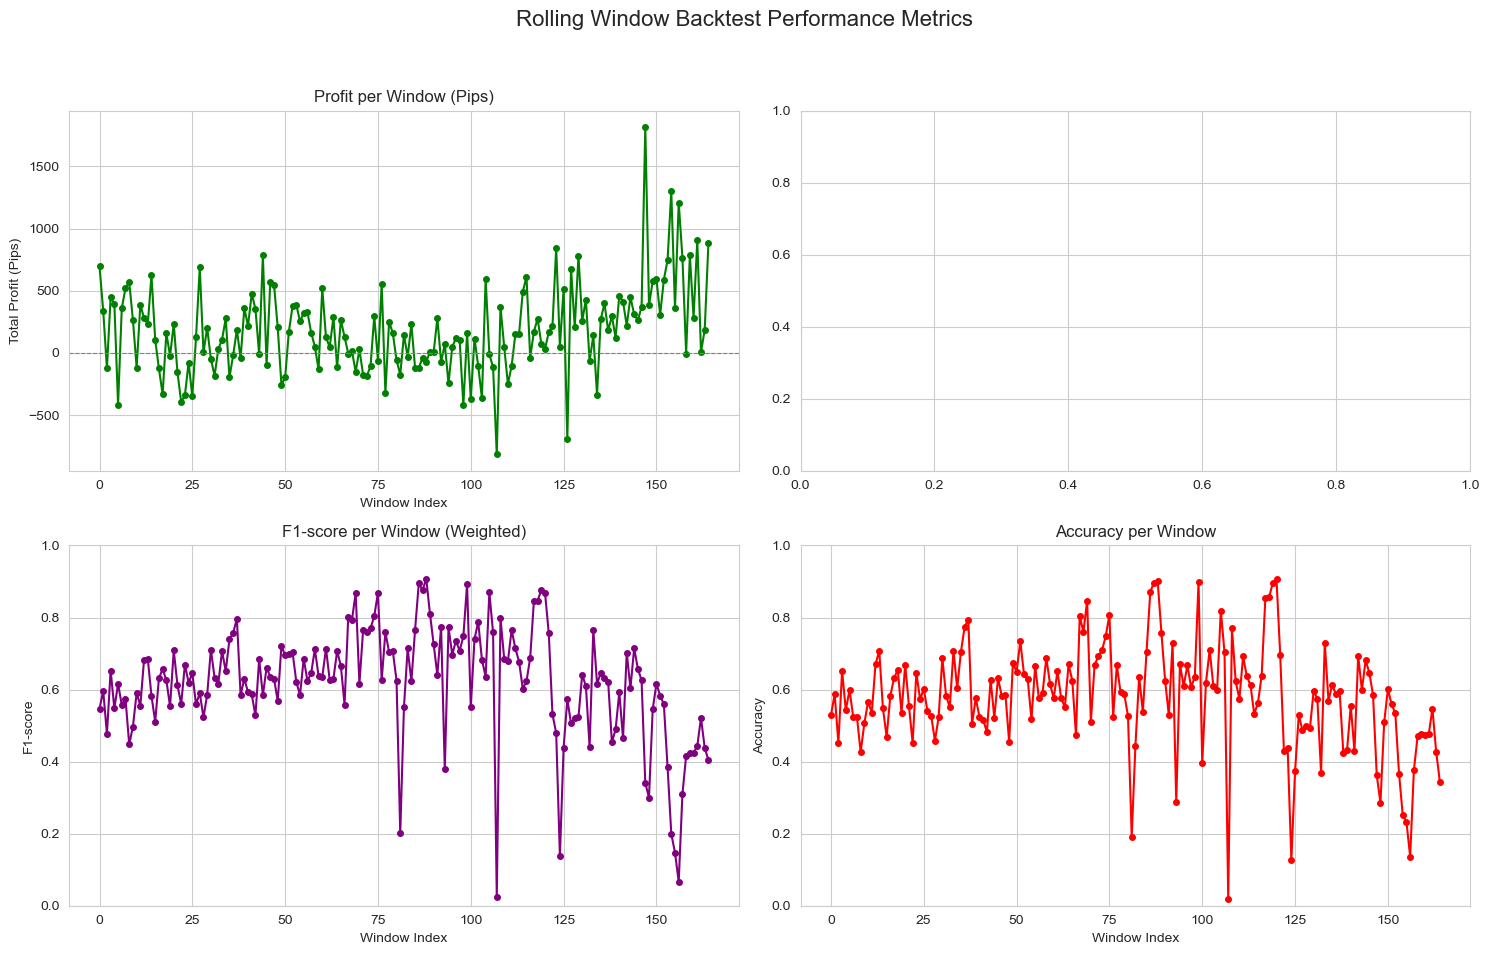


--- Overall Averages ---
Average F1-score: 0.620
Average Accuracy: 0.580
Total Profit: 30144.80 Pips


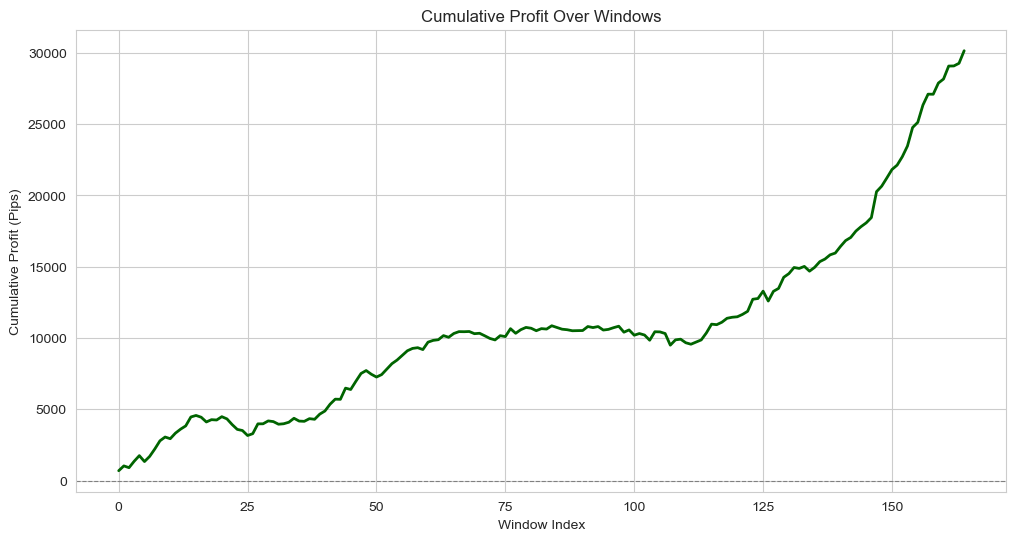

In [54]:
# Set a style for better visualization (optional)
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 10}) # Adjust font size if needed

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Rolling Window Backtest Performance Metrics', fontsize=16)

# Plot 1: Total Profit per Window
axes[0, 0].plot(window_indices, profit_per_window, marker='o', linestyle='-', color='green', markersize=4)
axes[0, 0].set_title('Profit per Window (Pips)')
axes[0, 0].set_xlabel('Window Index')
axes[0, 0].set_ylabel('Total Profit (Pips)')
axes[0, 0].grid(True)
axes[0, 0].axhline(0, color='gray', linestyle='--', linewidth=0.8) # Add a zero line for profit

'''# Plot 2: Number of Trades per Window
axes[0, 1].plot(window_indices, trades_per_window, marker='o', linestyle='-', color='blue', markersize=4)
axes[0, 1].set_title('Number of Trades per Window')
axes[0, 1].set_xlabel('Window Index')
axes[0, 1].set_ylabel('Number of Trades')
axes[0, 1].grid(True)'''

# Plot 3: F1-score per Window
axes[1, 0].plot(window_indices, f1_per_window, marker='o', linestyle='-', color='purple', markersize=4)
axes[1, 0].set_title('F1-score per Window (Weighted)')
axes[1, 0].set_xlabel('Window Index')
axes[1, 0].set_ylabel('F1-score')
axes[1, 0].grid(True)
axes[1, 0].set_ylim(0, 1) # F1-score is between 0 and 1

# Plot 4: Accuracy per Window
axes[1, 1].plot(window_indices, acc_per_window, marker='o', linestyle='-', color='red', markersize=4)
axes[1, 1].set_title('Accuracy per Window')
axes[1, 1].set_xlabel('Window Index')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].grid(True)
axes[1, 1].set_ylim(0, 1) # Accuracy is between 0 and 1

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle
plt.show()

# You might also want to calculate overall averages
print("\n--- Overall Averages ---")
print(f"Average F1-score: {np.mean(f1_per_window):.3f}")
print(f"Average Accuracy: {np.mean(acc_per_window):.3f}")
print(f"Total Profit: {np.sum(profit_per_window):.2f} Pips")
# print(f"Total Trades: {np.sum(trades_per_window)}")

# Plot cumulative profit
plt.figure(figsize=(12, 6))
plt.plot(window_indices, np.cumsum(profit_per_window), color='darkgreen', linewidth=2)
plt.title('Cumulative Profit Over Windows')
plt.xlabel('Window Index')
plt.ylabel('Cumulative Profit (Pips)')
plt.grid(True)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.show()